# PCA segmentation and KMeans to identify groups
- Does not look promising at all

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings
import joblib

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [4, 4]


In [2]:
Spend_prepared = pd.read_csv("FE/df_Spend_prepared_scaled.csv")
Spend_prepared.drop(columns=['cc_cons','cc_cons_quantileTransformed','region_code'], inplace=True) 
Spend_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14463 entries, 0 to 14462
Data columns (total 95 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            14463 non-null  int64  
 1   NetBanking_Flag               14463 non-null  float64
 2   FE_isSaving                   14463 non-null  float64
 3   FE_isFemale                   14463 non-null  float64
 4   Emp_Tenure_Years              14463 non-null  float64
 5   Tenure_with_Bank              14463 non-null  float64
 6   Avg_days_between_transaction  14463 non-null  float64
 7   FE_age_noOutlierErrors        14463 non-null  float64
 8   card_lim                      14463 non-null  float64
 9   trading                       14463 non-null  float64
 10  CDs                           14463 non-null  float64
 11  LifeInsurance                 14463 non-null  float64
 12  emi_active                    14463 non-null  float64
 13  s

In [3]:
other_numeric_cols = ['Emp_Tenure_Years','Tenure_with_Bank', 'Avg_days_between_transaction', 'FE_age_noOutlierErrors']
cols_to_logScale = ['card_lim','trading','CDs','LifeInsurance','emi_active','sum_cc_cons','sum_dc_cons',
                    'sum_cc_count','sum_dc_count','sum_debit_amount','sum_credit_amount','sum_debit_count',
                    'sum_credit_count','MAX_credit_amount','Neg_GeneralInsurance','Pos_GeneralInsurance']
OHE_coded = ['Income','FE_region_id']
numeric_cols_all = other_numeric_cols+cols_to_logScale

In [4]:
Spend_prepared[numeric_cols_all].describe()

,Emp_Tenure_Years,Tenure_with_Bank,Avg_days_between_transaction,FE_age_noOutlierErrors,card_lim,trading,CDs,LifeInsurance,emi_active,sum_cc_cons,sum_dc_cons,sum_cc_count,sum_dc_count,sum_debit_amount,sum_credit_amount,sum_debit_count,sum_credit_count,MAX_credit_amount,Neg_GeneralInsurance,Pos_GeneralInsurance
count,1.446300e+04,1.446300e+04,1.446300e+04,1.446300e+04,1.446300e+04,1.446300e+04,1.446300e+04,1.446300e+04,1.446300e+04,1.446300e+04,1.446300e+04,1.446300e+04,1.446300e+04,1.446300e+04,1.446300e+04,1.446300e+04,1.446300e+04,1.446300e+04,1.446300e+04,1.446300e+04
mean,4.618061e-17,8.499197e-17,7.958786e-17,1.213469e-16,-5.128995e-16,-8.351813e-18,8.125822e-16,2.417113e-16,1.021869e-15,-1.149602e-15,-3.026304e-16,1.454198e-16,2.220600e-16,-2.000505e-15,-2.957524e-16,1.329903e-15,-6.141039e-16,7.433113e-16,1.002218e-16,-1.228208e-17
std,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00
min,-1.192619e+00,-1.573730e+00,-1.648099e+00,-1.448811e+00,-1.105284e+01,-3.642150e+00,-4.669480e+00,-1.718394e+00,-4.949237e+00,-4.280041e+00,-3.944505e+00,-3.974730e+00,-3.050851e+00,-4.374835e+00,-7.598995e+00,-5.560581e+00,-3.369433e+00,-3.890029e+00,-5.240226e-01,-1.555660e+00
25%,-7.433871e-01,-8.757584e-01,-9.201737e-01,-7.928175e-01,-4.167269e-01,-5.844225e-01,-3.219015e-01,-8.673912e-01,-4.914872e-01,-6.430304e-01,-6.477842e-01,-5.562509e-01,-5.761128e-01,-6.612957e-01,-6.498510e-01,-5.397732e-01,-8.522840e-01,-7.162978e-01,-5.240226e-01,-1.555660e+00
50%,-2.841727e-01,1.711993e-01,-1.026735e-02,-3.828216e-01,2.956540e-01,1.383314e-01,1.845076e-01,1.301229e-01,7.677253e-02,2.506414e-03,-2.364272e-02,7.264731e-02,2.545796e-01,-5.315332e-02,-4.053358e-02,1.411981e-01,1.625076e-01,-1.463716e-01,-5.240226e-01,4.623155e-01
75%,4.345978e-01,8.691711e-01,8.996390e-01,8.471662e-01,6.454085e-01,6.009737e-01,5.601321e-01,8.155892e-01,6.008367e-01,6.542072e-01,6.249535e-01,5.835496e-01,7.456200e-01,5.959909e-01,5.900999e-01,7.124090e-01,7.273472e-01,5.321471e-01,-5.240226e-01,7.415571e-01
max,3.649099e+00,1.567143e+00,1.627564e+00,2.159153e+00,1.476387e+00,2.775239e+00,1.991008e+00,2.187084e+00,4.654388e+00,4.770884e+00,5.071621e+00,3.436086e+00,1.871024e+00,5.791702e+00,6.092999e+00,2.360289e+00,2.379525e+00,6.743492e+00,2.136313e+00,1.166759e+00


In [5]:
def corr_plot(cols, cust_df, width=5, height=4, show_corr = True, font_cex=1):
    sns.reset_defaults()
    corr_cols_list = cols
    correl = cust_df[corr_cols_list].corr()
    ## correl
    mask = np.zeros_like(correl)
    mask[np.triu_indices_from(mask)] = True 
    fig, ax = plt.subplots( figsize=(width,height) )
    ## fmt='.1g' says one decimal space
    ## vmin defines the lower value of a heatmap
    sns.heatmap(correl, mask=mask, vmin=correl.min().min(), vmax=correl.max().max(), cmap="tab20c", annot=show_corr, fmt='.3f')
    ax.set_title(f"correlation of {correl.shape[1]} columns. \n Check as sometimes columns are dynamically removed.", fontsize=10)
    sns.set(font_scale=font_cex)
    plt.show()
    return correl

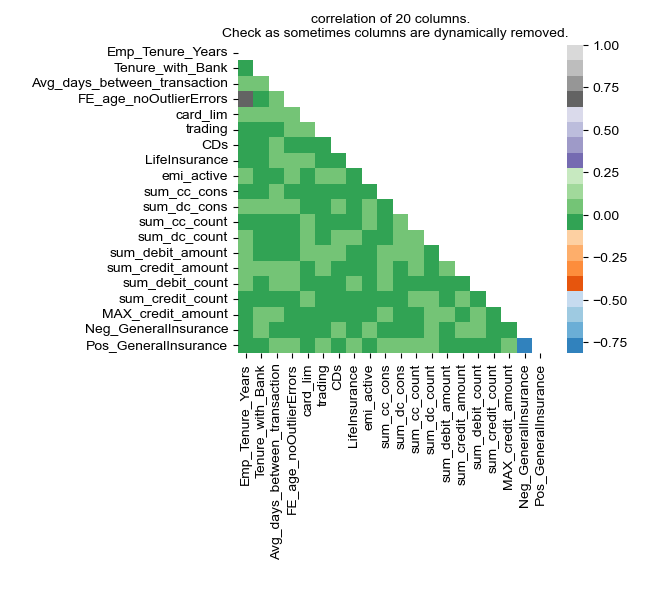

In [6]:
corr = corr_plot(cols=numeric_cols_all, cust_df=Spend_prepared, show_corr = False)

In [7]:
## https://learn.365datascience.com/courses/customer-analytics-in-python/principal-component-analysis-application/
id_col = Spend_prepared['ID']
Spend_prepared = Spend_prepared.drop('ID', axis=1)
pca = PCA()
pca.fit(Spend_prepared)

PCA()

In [8]:
pca.explained_variance_ratio_
len(pca.explained_variance_ratio_)

94

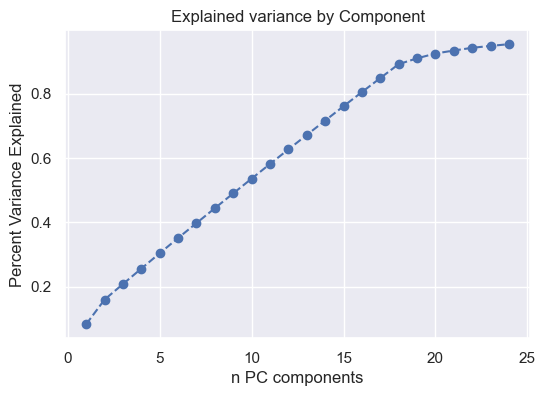

In [9]:
plt.figure(figsize=(6,4))
plt.plot(range(1,25), pca.explained_variance_ratio_[:24].cumsum(), marker="o", linestyle="--")
plt.title("Explained variance by Component")
plt.xlabel("n PC components")
plt.ylabel("Percent Variance Explained")
plt.show()

In [10]:
pca = PCA(n_components = 19)
pca.fit(Spend_prepared)

PCA(n_components=19)

In [11]:
## pca.components_
len(pca.components_)

19

In [12]:
PCs = []
for i in range(1,20):
    PCs.append(f'PC{i}')
print(PCs)
Spend_prepared_PCA = pd.DataFrame(data=pca.components_,
                                  columns=Spend_prepared.columns.values,
                                  index = PCs)
Spend_prepared_PCA

['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19']


,NetBanking_Flag,FE_isSaving,FE_isFemale,Emp_Tenure_Years,Tenure_with_Bank,Avg_days_between_transaction,FE_age_noOutlierErrors,card_lim,trading,CDs,...,FE_region_id_864.0-866.0,FE_region_id_867.0-867.0,FE_region_id_874.0-883.0,FE_region_id_884.0-908.0,FE_region_id_911.0-914.0,FE_region_id_921.0-927.0,FE_region_id_928.0-945.0,FE_region_id_950.0-958.0,FE_region_id_963.0-966.0,FE_region_id_968.0-974.0
PC1,0.003547,0.001779,0.002555,-0.017165,0.028044,-0.009818,-0.027617,-0.006090,-0.006394,0.026580,...,-0.001232,-0.000544,-0.000245,-0.000826,-0.000091,0.000312,2.321427e-04,0.000205,0.000546,0.000185
PC2,-0.001055,0.001088,0.001071,0.705836,-0.006616,0.018173,0.705064,0.008989,0.005846,-0.022168,...,-0.001111,0.000354,-0.001397,-0.000427,0.000594,0.000374,6.497687e-04,0.000376,0.000174,-0.000489
PC3,0.001848,-0.005463,-0.002454,0.012562,-0.060363,0.220913,0.003831,-0.158500,-0.357502,0.227849,...,-0.000588,0.000440,-0.000461,-0.001059,0.001413,-0.000777,6.037543e-04,-0.000804,0.002385,0.000079
PC4,-0.006182,0.000298,-0.002297,-0.002574,0.216599,0.056797,0.007911,-0.294802,0.065923,-0.281279,...,-0.000527,0.000352,-0.000089,-0.000473,-0.001412,-0.001001,2.116265e-03,0.001245,-0.000751,0.001481
PC5,-0.002504,-0.000586,0.001004,-0.010029,-0.160027,0.032014,-0.012157,-0.448426,0.297730,0.316420,...,0.000648,-0.002367,0.000284,0.000832,0.001586,0.000160,-2.433377e-03,-0.000211,0.001374,0.000196
PC6,0.000043,-0.001819,0.003466,0.012557,-0.572426,-0.337233,0.002974,-0.015458,0.164281,0.005917,...,0.001743,0.001909,-0.001019,0.000212,-0.000251,0.000504,-3.483133e-05,-0.000153,-0.001266,-0.000024
PC7,0.004353,0.004386,0.003556,0.000657,-0.000147,0.191638,-0.008258,-0.018933,-0.356712,-0.079659,...,-0.000466,-0.000749,-0.000182,0.001507,-0.000223,0.000490,-5.904794e-04,0.000597,-0.001178,0.000025
PC8,-0.001475,-0.001580,0.000716,0.006113,-0.046432,-0.389016,0.012777,-0.440764,-0.340100,-0.220955,...,0.000451,0.000172,0.001482,0.000603,0.000412,-0.001519,8.952487e-04,0.001947,0.000161,0.000658
PC9,-0.000806,-0.003295,-0.003935,0.010490,0.428394,-0.448465,0.003602,-0.124855,0.153097,-0.111851,...,-0.000225,0.000241,-0.000433,-0.001375,0.000378,-0.000398,-1.495088e-04,0.001064,-0.000966,-0.000179
PC10,0.003004,0.003226,0.000673,0.001840,0.105604,0.131623,0.012009,-0.086915,-0.039573,-0.140372,...,0.000394,0.000395,-0.001206,-0.000707,-0.000053,-0.001368,-3.443289e-04,-0.000186,0.001456,-0.000257


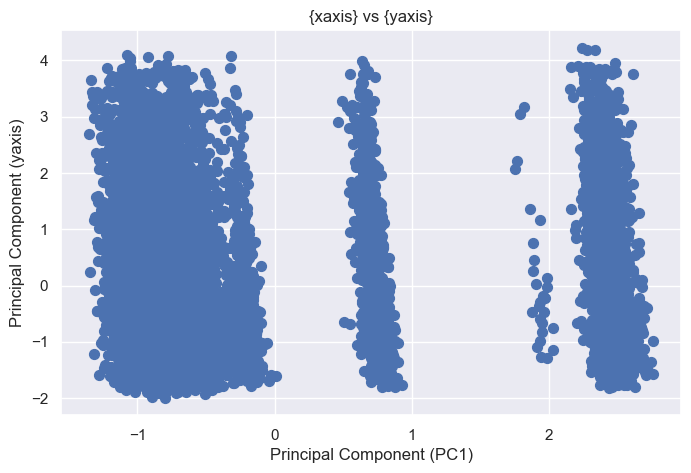

In [13]:
pca_components = pca.transform(Spend_prepared)
pca_df = pd.DataFrame(pca_components, columns=PCs)
xaxis = 'PC1'
yaxis = 'PC2'
plt.figure(figsize=(8, 5))
plt.scatter(pca_df[xaxis], pca_df[yaxis], s=50)
plt.xlabel(f'Principal Component ({xaxis})')
plt.ylabel(f'Principal Component (yaxis)')
plt.title('{xaxis} vs {yaxis}')
plt.grid(True)
plt.show()

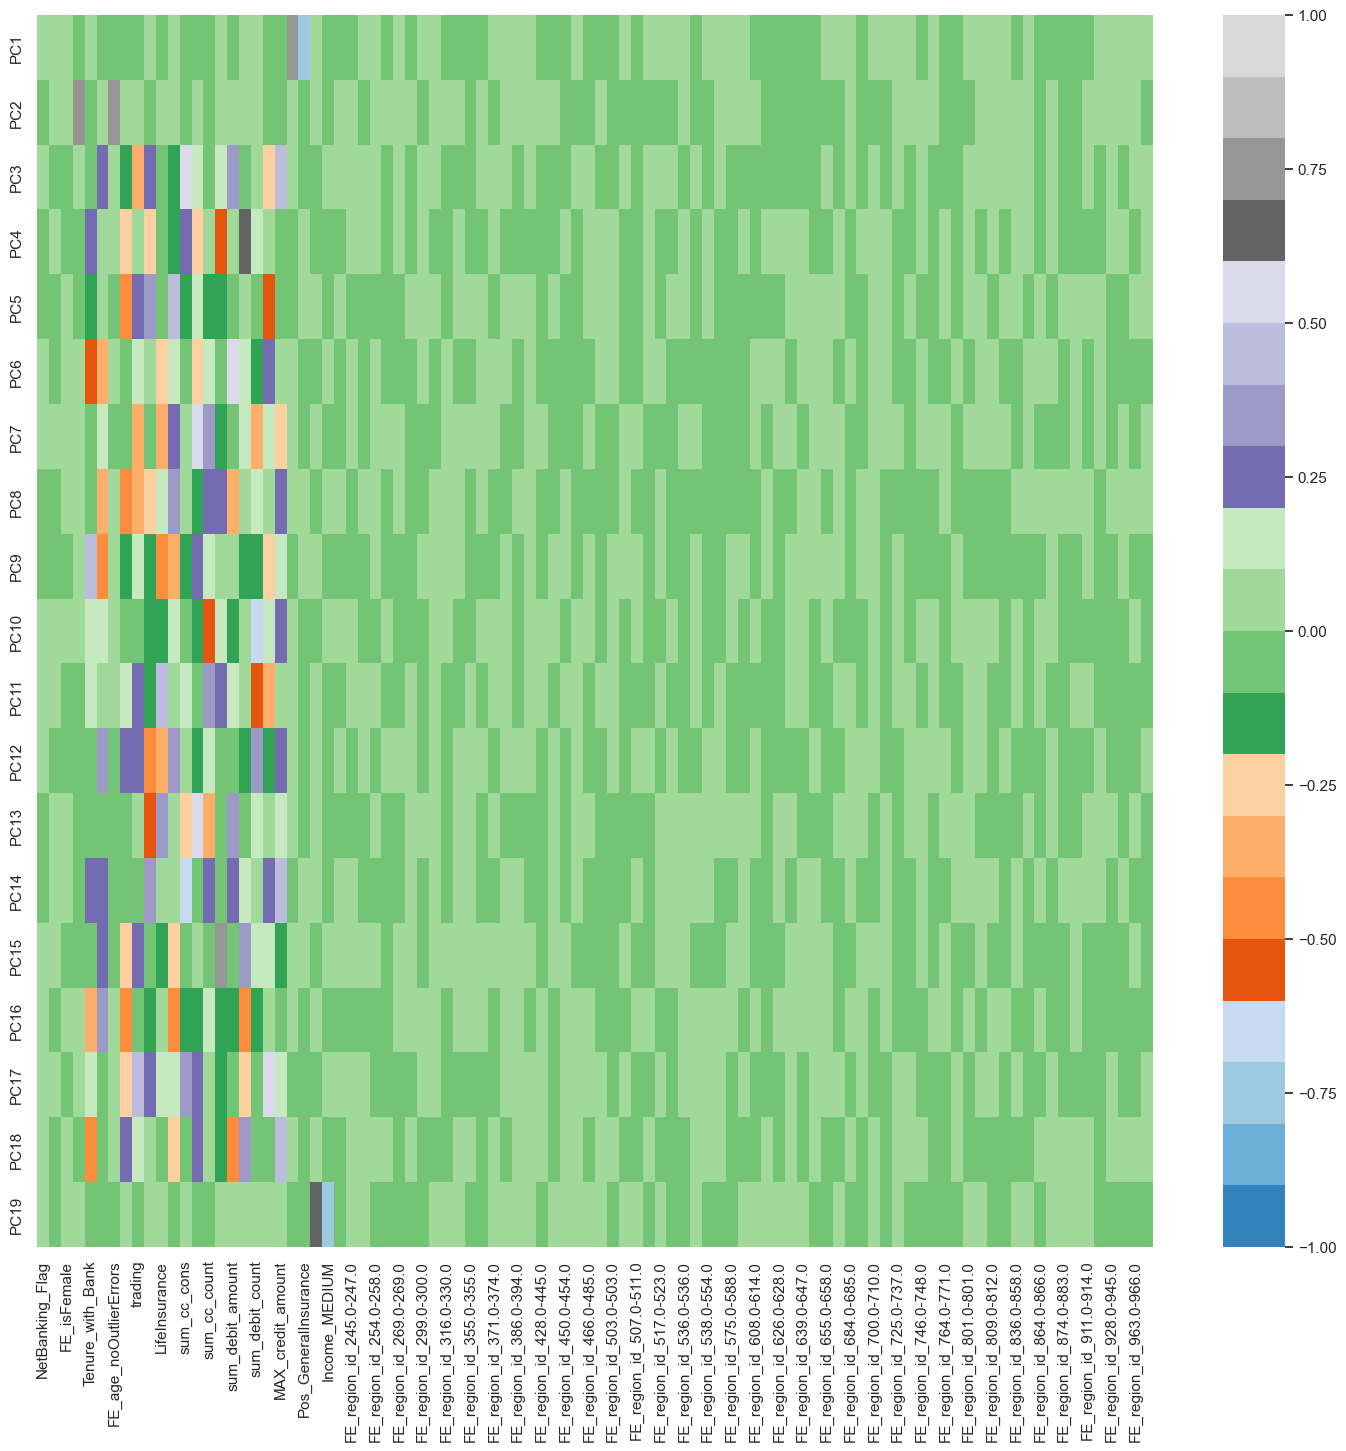

In [14]:
plt.figure(figsize=(18,16))
sns.heatmap(Spend_prepared_PCA,vmin=-1,vmax=1, cmap="tab20c", annot=False)
plt.show()
corr_long_table = Spend_prepared_PCA.reset_index().melt(id_vars='index')

corr_long_table.columns = ['Variable1', 'Variable2', 'Correlation']
corr_long_table.to_csv("tmp/PCA_table.csv")

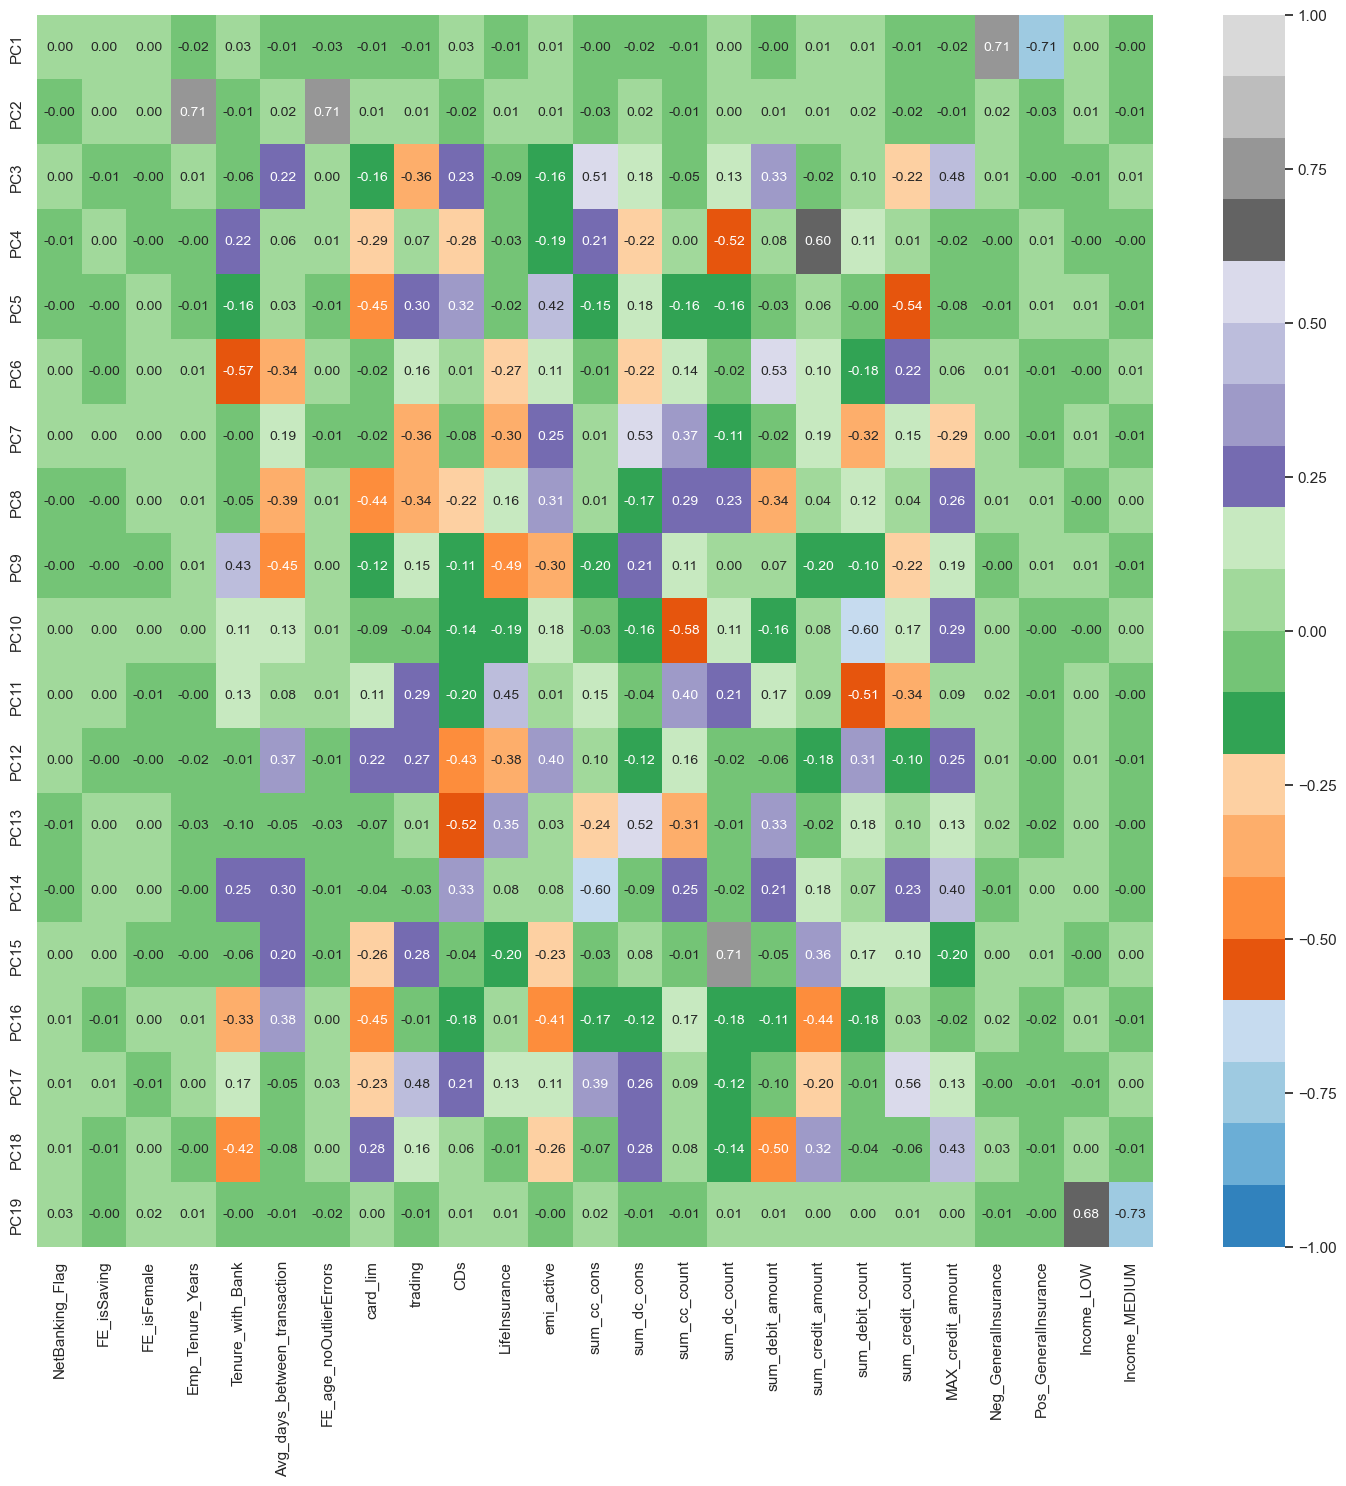

In [15]:
cols_drop = [col for col in Spend_prepared_PCA.columns if col.startswith('FE_region_id')]
Spend_prepared_PCA_corr = Spend_prepared_PCA.drop(columns=cols_drop)

plt.figure(figsize=(18,16))
sns.heatmap(Spend_prepared_PCA_corr,vmin=-1,vmax=1, cmap="tab20c", annot=True,fmt=".2f", annot_kws = {"size":10})
plt.show()

In [16]:
scores_pca = pca.transform(Spend_prepared)

## K-means clustering with PCA

In [17]:
wcss = []
for i in range(1,40):
    Kmeans = KMeans(n_clusters = i, init='k-means++',random_state=42)
    Kmeans.fit(scores_pca)
    wcss.append(Kmeans.inertia_)

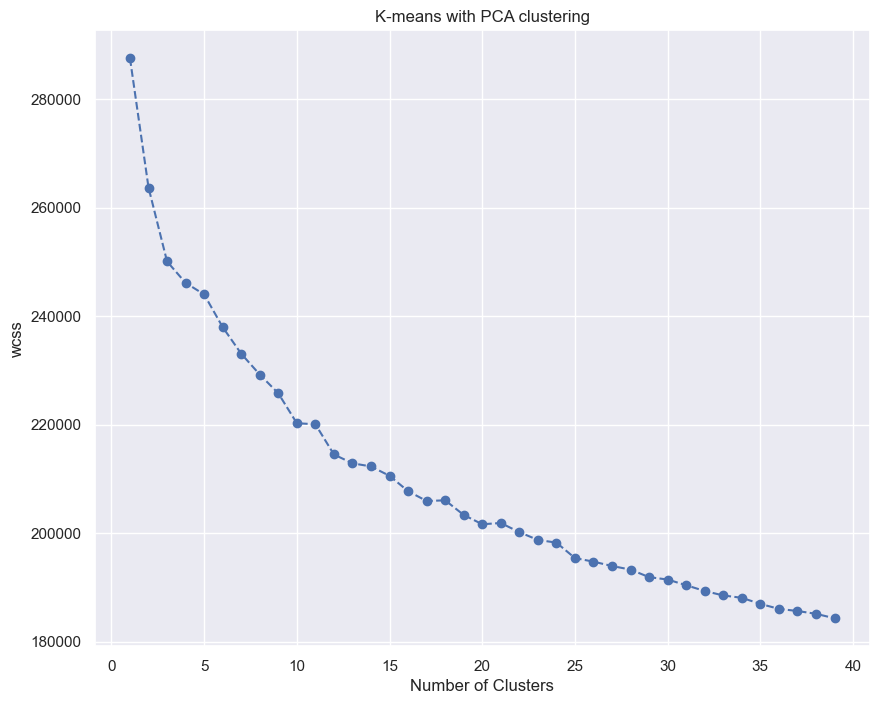

In [18]:
plt.figure(figsize=(10,8))
plt.plot(range(1,40), wcss, marker="o", linestyle="--")
plt.xlabel('Number of Clusters')
plt.ylabel('wcss')
plt.title('K-means with PCA clustering')
plt.show()

In [19]:
Kmeans_pca = KMeans(n_clusters=5, init='k-means++', random_state=42)

In [20]:
Kmeans_pca.fit(scores_pca)

KMeans(n_clusters=5, random_state=42)

In [21]:
len(Kmeans_pca.labels_)

14463

In [22]:
scores_pca_df = pd.DataFrame(scores_pca)
colnames = []
for i in scores_pca_df.columns:
    colnames.append(f'PC{i+1}')
scores_pca_df.columns = colnames
scores_pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
0,-0.969068,-0.183099,1.131290,-0.399747,-0.324548,-0.371689,1.194813,-0.340755,-0.301831,0.472417,-0.705306,1.218621,1.040943,-2.000811,1.140461,0.338499,-2.340601,0.797534,-0.474077
1,-0.534819,-0.293796,-0.491950,0.742100,0.206903,-0.117835,-2.503966,0.291317,-1.938967,1.107254,-0.547619,0.238289,-0.421903,0.440239,0.239243,-0.441197,0.366477,-1.004929,0.342321
2,-0.801963,1.533576,-0.945510,-0.965645,1.256785,1.129952,-0.380346,1.286382,-0.718403,-1.352824,0.144757,-0.227073,-0.828277,-0.552632,0.350091,-0.810477,-0.120156,0.534573,-0.456524
3,2.479745,-1.315092,-0.591021,1.398422,0.025466,0.088227,0.108109,0.344173,-0.378612,-1.029286,-0.595101,-0.934583,0.239570,-0.281432,-0.715025,-0.843816,1.472607,0.743695,-0.393565
4,-0.852102,-0.508624,-0.907234,-1.730998,-0.607853,0.265526,0.538974,1.328568,-1.250496,-1.183593,-0.028533,-1.354436,0.204473,0.982944,0.110726,-0.527622,-0.553823,-0.681582,-0.410606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14458,-0.663937,-1.671356,0.339331,0.006301,0.397321,0.450986,1.718544,-1.949033,0.508616,-0.404158,-0.226917,0.953608,0.140066,-0.541898,-0.345024,0.183705,0.106369,-0.263128,-0.458334
14459,-0.544189,0.754991,0.285480,-1.247711,0.535730,-0.336885,-0.335999,-1.190646,-0.287128,0.989892,1.186535,1.800898,1.023151,0.948581,0.024330,-0.886969,-0.417986,-2.119993,0.954586
14460,2.522429,-0.629715,0.142503,0.165170,0.201806,-0.677938,-1.055590,0.025220,1.319137,0.777772,-0.237076,-0.199657,-0.265637,-0.419098,-2.683211,-0.938945,0.487715,0.750287,-0.459892
14461,-0.841555,-1.122576,-0.570354,2.058014,0.060756,0.196684,-0.762855,0.809730,-0.123662,0.128780,0.654611,-0.835672,-1.719923,0.302688,0.182171,-0.169193,0.950937,-0.993058,-0.405870


In [23]:
Kmeans_pca.labels_

array([2, 2, 1, ..., 3, 2, 3], dtype=int32)

In [24]:
df_segm_pca_Kmeans = pd.concat([Spend_prepared.reset_index(drop=True), scores_pca_df], axis=1).reset_index()
df_segm_pca_Kmeans['Segment_PCA_Kmeans'] = Kmeans_pca.labels_




df_segm_pca_Kmeans_freq = df_segm_pca_Kmeans.groupby(['Segment_PCA_Kmeans']).mean()

In [25]:
df_segm_pca_Kmeans_freq['n_obs'] = df_segm_pca_Kmeans[['Segment_PCA_Kmeans','FE_isFemale']].groupby(['Segment_PCA_Kmeans']).count()
df_segm_pca_Kmeans_freq['prop_obs'] = df_segm_pca_Kmeans_freq['n_obs']/df_segm_pca_Kmeans_freq['n_obs'].sum()
df_segm_pca_Kmeans_freq

,index,NetBanking_Flag,FE_isSaving,FE_isFemale,Emp_Tenure_Years,Tenure_with_Bank,Avg_days_between_transaction,FE_age_noOutlierErrors,card_lim,trading,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,n_obs,prop_obs
Segment_PCA_Kmeans,,,,,,,,,,,,,,,,,,,,,
0,7195.461702,0.748936,0.169149,0.140426,1.406488,0.026779,0.081885,1.315696,0.081934,-0.029867,...,0.019478,-0.015612,0.023920,-0.051324,-0.032341,-0.026996,0.061261,-0.016505,940,0.064993
1,7227.280682,0.712784,0.148011,0.138920,1.025252,-0.015984,-0.007682,1.180987,0.010565,-0.006819,...,-0.031157,-0.026723,-0.014622,-0.000967,-0.021639,-0.005192,-0.017453,-0.003816,3520,0.243380
2,7201.787735,0.716326,0.153178,0.133016,-0.507803,-0.013066,0.009404,-0.567371,0.000120,0.006841,...,0.011325,-0.002774,0.011752,0.002526,-0.000134,-0.001944,0.000867,-0.000030,7142,0.493812
3,7238.352538,0.711248,0.145405,0.141289,-0.452424,-0.036325,-0.886224,-0.472413,0.090039,-0.016162,...,-0.215578,0.117448,-0.257788,-0.045010,-0.347273,0.010570,0.129615,0.008941,1458,0.100809
4,7405.206700,0.724875,0.157520,0.146828,-0.459461,0.126426,0.837509,-0.465347,-0.175580,0.019092,...,0.231498,-0.030423,0.228731,0.070726,0.437526,0.030025,-0.136365,0.011493,1403,0.097006


In [26]:
df_segm_pca_Kmeans_freq = df_segm_pca_Kmeans_freq.rename({0: 'older_lowUsers',
                                                                    1: 'older_dcUsers',
                                                                    2: 'younger_dcUsers',
                                                                    3: 'younger_freqUsers',
                                                                    4: 'younger_infreqUsers'})
df_segm_pca_Kmeans_freq

,index,NetBanking_Flag,FE_isSaving,FE_isFemale,Emp_Tenure_Years,Tenure_with_Bank,Avg_days_between_transaction,FE_age_noOutlierErrors,card_lim,trading,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,n_obs,prop_obs
Segment_PCA_Kmeans,,,,,,,,,,,,,,,,,,,,,
older_lowUsers,7195.461702,0.748936,0.169149,0.140426,1.406488,0.026779,0.081885,1.315696,0.081934,-0.029867,...,0.019478,-0.015612,0.023920,-0.051324,-0.032341,-0.026996,0.061261,-0.016505,940,0.064993
older_dcUsers,7227.280682,0.712784,0.148011,0.138920,1.025252,-0.015984,-0.007682,1.180987,0.010565,-0.006819,...,-0.031157,-0.026723,-0.014622,-0.000967,-0.021639,-0.005192,-0.017453,-0.003816,3520,0.243380
younger_dcUsers,7201.787735,0.716326,0.153178,0.133016,-0.507803,-0.013066,0.009404,-0.567371,0.000120,0.006841,...,0.011325,-0.002774,0.011752,0.002526,-0.000134,-0.001944,0.000867,-0.000030,7142,0.493812
younger_freqUsers,7238.352538,0.711248,0.145405,0.141289,-0.452424,-0.036325,-0.886224,-0.472413,0.090039,-0.016162,...,-0.215578,0.117448,-0.257788,-0.045010,-0.347273,0.010570,0.129615,0.008941,1458,0.100809
younger_infreqUsers,7405.206700,0.724875,0.157520,0.146828,-0.459461,0.126426,0.837509,-0.465347,-0.175580,0.019092,...,0.231498,-0.030423,0.228731,0.070726,0.437526,0.030025,-0.136365,0.011493,1403,0.097006


In [27]:
df_segm_pca_Kmeans['legend'] = df_segm_pca_Kmeans['Segment_PCA_Kmeans'].map({0: 'older_lowUsers',
                                                                    1: 'older_dcUsers',
                                                                    2: 'younger_dcUsers',
                                                                    3: 'younger_freqUsers',
                                                                    4: 'younger_infreqUsers'})
df_segm_pca_Kmeans

,index,NetBanking_Flag,FE_isSaving,FE_isFemale,Emp_Tenure_Years,Tenure_with_Bank,Avg_days_between_transaction,FE_age_noOutlierErrors,card_lim,trading,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,Segment_PCA_Kmeans,legend
0,0,0.0,0.0,0.0,0.254905,-1.573730,1.081620,-0.628819,0.710996,-1.426811,...,1.218621,1.040943,-2.000811,1.140461,0.338499,-2.340601,0.797534,-0.474077,2,younger_dcUsers
1,1,0.0,0.0,0.0,0.254905,0.171199,0.535676,-0.628819,-0.391484,0.701574,...,0.238289,-0.421903,0.440239,0.239243,-0.441197,0.366477,-1.004929,0.342321,2,younger_dcUsers
2,2,1.0,0.0,0.0,1.203283,-1.573730,-1.466117,1.011165,0.016794,0.610256,...,-0.227073,-0.828277,-0.552632,0.350091,-0.810477,-0.120156,0.534573,-0.456524,1,older_dcUsers
3,3,1.0,0.0,1.0,-0.793302,0.171199,-1.284136,-1.120814,-0.214361,0.354804,...,-0.934583,0.239570,-0.281432,-0.715025,-0.843816,1.472607,0.743695,-0.393565,3,younger_freqUsers
4,4,1.0,0.0,0.0,0.015315,-0.526773,-0.738192,-0.710818,0.375397,-1.441977,...,-1.354436,0.204473,0.982944,0.110726,-0.527622,-0.553823,-0.681582,-0.410606,2,younger_dcUsers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14458,14458,1.0,0.0,0.0,-1.102772,-0.177787,0.899639,-1.284813,0.649932,0.331576,...,0.953608,0.140066,-0.541898,-0.345024,0.183705,0.106369,-0.263128,-0.458334,2,younger_dcUsers
14459,14459,1.0,0.0,1.0,0.075213,1.218157,1.627564,0.847166,0.883345,0.651971,...,1.800898,1.023151,0.948581,0.024330,-0.886969,-0.417986,-2.119993,0.954586,1,older_dcUsers
14460,14460,1.0,0.0,0.0,-1.002943,1.218157,-1.648099,0.109173,0.795512,-0.076701,...,-0.199657,-0.265637,-0.419098,-2.683211,-0.938945,0.487715,0.750287,-0.459892,3,younger_freqUsers
14461,14461,1.0,0.0,0.0,-0.903114,1.218157,-0.556211,-0.464821,-1.356341,0.640977,...,-0.835672,-1.719923,0.302688,0.182171,-0.169193,0.950937,-0.993058,-0.405870,2,younger_dcUsers


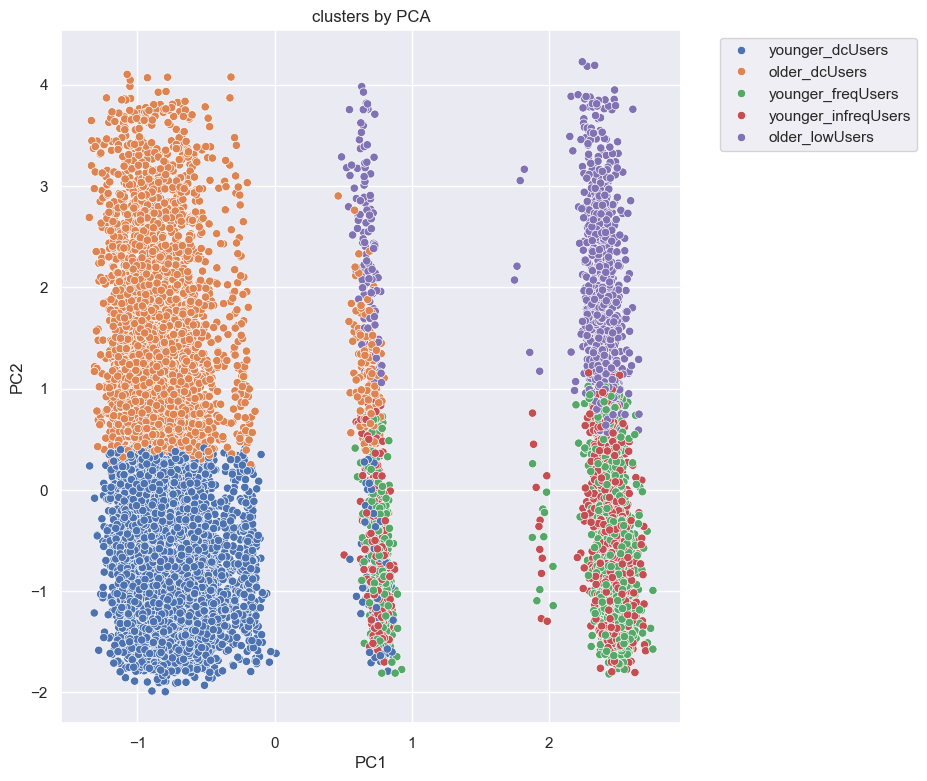

In [28]:
xaxis = 'PC1'
yaxis = 'PC2'
plt.figure(figsize=(8,9))
sns.scatterplot(data =df_segm_pca_Kmeans, x=xaxis, y=yaxis, hue='legend')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('clusters by PCA')
plt.show()

In [29]:
df_segm_pca_Kmeans.columns

Index(['index', 'NetBanking_Flag', 'FE_isSaving', 'FE_isFemale',
       'Emp_Tenure_Years', 'Tenure_with_Bank', 'Avg_days_between_transaction',
       'FE_age_noOutlierErrors', 'card_lim', 'trading',
       ...
       'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19',
       'Segment_PCA_Kmeans', 'legend'],
      dtype='object', length=116)

In [30]:
df_segm_pca_Kmeans['ID'] = id_col
joblib.dump(pca, 'FE/NB3_pca.pkl')
joblib.dump(Kmeans_pca, 'FE/Kmeans_pca.pkl')
## ohe = joblib.load('NB2_OHE_left_to_code.pkl')
df_segm_pca_Kmeans.to_csv("FE/df_segm_pca_Kmeans.csv", index=False)
df_segm_pca_Kmeans_freq.to_csv("FE/df_segm_pca_Kmeans_freqSumm.csv", index=False)